### Notebook para geração do dataset de máscaras e sua avaliação

In [23]:
import numpy as np
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
# map_celula = {
#   "title" : None,
#   "img-inteira-title": None,
#   "img-inteira-plotada" : None,
#   "img" : None,
#   "img-seg" : None,
#   "img-mask" : None,
# }

In [68]:
diretorio_dataset_recortado_mask = "../data/base_mascara/"

In [69]:
def listar_imagens(diretorio_raiz, extensoes_imagens=None):
    if extensoes_imagens is None:
        extensoes_imagens = ['.jpg', '.jpeg', '.png']

    arquivos_imagens = []
    for dirpath, _, filenames in os.walk(diretorio_raiz):
        for filename in filenames:
            if any(filename.lower().endswith(extensao) for extensao in extensoes_imagens):
                caminho_completo = os.path.join(dirpath, filename)
                arquivos_imagens.append(caminho_completo)
    return arquivos_imagens

### Métodos Repetidos do **mask.ipynb**

In [6]:
def remover_fundo_com_grabcut_recortado(imagem):
    mascara = np.zeros(imagem.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    altura, largura = imagem.shape[:2]
    
    # Calcular os limites do retângulo
    x1 = 0
    y1 = 0
    x2 = largura - 1
    y2 = altura - 1
        
    rectangle = (x1, y1, x2 - x1, y2 - y1)
    
    print(f"Valor do ratangulo: {rectangle}")
    
    cv2.grabCut(imagem, mascara, rectangle,  
            backgroundModel, foregroundModel,
            3, cv2.GC_INIT_WITH_RECT)
    
    mascara_objeto = np.where((mascara == 2) | (mascara == 0), 0, 1).astype('uint8')
    
    imagem_sem_fundo = imagem * mascara_objeto[:, :, np.newaxis]
    
    img_recortada = imagem_sem_fundo[y1:y2, x1:x2]
    
    imagem_gray = cv2.cvtColor(img_recortada, cv2.COLOR_BGR2GRAY)
    
    _, mascara = cv2.threshold(imagem_gray, 10, 255, cv2.THRESH_BINARY)
    
    img_original_recortada = imagem[y1:y2, x1:x2]
    
    return img_recortada, mascara, img_original_recortada

In [5]:
def paint_quadrado_imagem_recortado(imagem, x_central, y_central):
  altura, largura = imagem.shape[:2]
    
  # Calcular os limites do retângulo
  x1 = 0
  y1 = 0
  x2 = largura - 1
  y2 = altura - 1

  imagem_com_quadrado = imagem.copy()
  cv2.rectangle(imagem_com_quadrado, (x1, y1), (x2, y2), (0, 255, 0), 2)  
  cv2.circle(imagem_com_quadrado, (x_central, y_central), 5, (0, 0, 255), -1) 

  imagem_com_quadrado_rgb = cv2.cvtColor(imagem_com_quadrado, cv2.COLOR_BGR2RGB)
  return imagem_com_quadrado_rgb

In [9]:
def generateMapSegmentad_Recortada(lista_map_celula, info_img):
  # value_expand = 70
  df = pd.read_csv("../data/classifications.csv")
  
  
  
  ###########################################################
  # No codigo de geração em massa USA O ID DA IMAGEM
  ###########################################################
  # df = df[df["image_filename"] == f"{info_img}.png"]
  df = df[df["cell_id"] == int(info_img) ]
  ###########################################################

  print(df)
  print("--------------\n\n\n")
  map_celula = {
    "title" : None,
    "img-inteira-title": None,
    "img-inteira-plotada" : None,
    "img" : None,
    "img-seg" : None,
    "img-mask" : None,
  }

  

  for i, each in enumerate(df.iterrows()):
    
    
    nome_img = each[1]['image_filename']
    nome_da_doenca = each[1]['bethesda_system']
    id_celular = each[1]['cell_id']  
    
    database = f"../data/base_recortada/{nome_da_doenca}/"
    
    try:
      
    
      path = "".join([database, str(id_celular)]) + ".png"
      print(path)
      imagem = cv2.imread(path)
      altura, largura = imagem.shape[:2]
      posi_x = largura // 2
      posi_y =  altura // 2
      imagem_sem_fundo, mask, img_original_recortada = remover_fundo_com_grabcut_recortado(imagem)
      
      map_celula["img"] = img_original_recortada
      map_celula["title"] = f"{nome_da_doenca} - {id_celular}"
      map_celula["img-inteira-title"] = nome_img
      map_celula["img-seg"] = imagem_sem_fundo
      map_celula["img-mask"] = mask
      
      map_celula["img-inteira-plotada"] =  paint_quadrado_imagem_recortado(imagem, posi_x, posi_y)
      lista_map_celula.append(map_celula.copy())
      # print(i)
      print(nome_da_doenca +  " " + str(id_celular))
    except:
      print(f"Deu erro: {database}")
  return lista_map_celula
  

### Inicio código de geração do dataset

In [70]:
path = '../data/base_recortada/'
img_path_list = []
img_path_list = listar_imagens(path)


for each_img in img_path_list:
  lista_map_celula = []
  
  # img_name = each_img.split("/")
  # img_name = img_name[len(img_name)-1].replace(".png", "")
  img_name = each_img.split('\\')
  img_name = img_name[len(img_name)-1].replace(".png", "")

  lista_map_celula = generateMapSegmentad_Recortada(lista_map_celula, img_name)
  
  for each_map in lista_map_celula:
    
    title = each_map["title"].split("-")
    id_celular = title[len(title)-1].strip()
    nome_da_doenca = title[0].strip()
    
    if(len(each_map["img-mask"])!= 0):    

      if not os.path.exists(os.path.join(diretorio_dataset_recortado_mask, nome_da_doenca)):
        os.mkdir(os.path.join(diretorio_dataset_recortado_mask, nome_da_doenca))
    
      try:
        cv2.imwrite(f'{diretorio_dataset_recortado_mask}{nome_da_doenca}/' + f'{id_celular}.png', each_map["img-mask"])
      except:
        print("Erro")
        print(each_map["title"])
      
      
  


  
  

   image_id                        image_filename  \
9       400  9ae8a4edde40219bad6303cebc672ee4.png   

                      image_doi  cell_id bethesda_system  nucleus_x  nucleus_y  
9  10.6084/m9.figshare.12230906       10           ASC-H        638        245  
--------------



../data/base_recortada/ASC-H/10.png
Valor do ratangulo: (0, 0, 199, 199)
ASC-H 10
       image_id                        image_filename  \
10070        46  2c0c4f9db92dc5b996c4e1b90aa2a0ec.png   

                          image_doi  cell_id bethesda_system  nucleus_x  \
10070  10.6084/m9.figshare.12229664    10071           ASC-H        309   

       nucleus_y  
10070        468  
--------------



../data/base_recortada/ASC-H/10071.png
Valor do ratangulo: (0, 0, 199, 199)
ASC-H 10071
       image_id                        image_filename  \
10071        46  2c0c4f9db92dc5b996c4e1b90aa2a0ec.png   

                          image_doi  cell_id bethesda_system  nucleus_x  \
10071  10.6084/m9.figshare.1222

### Analise das Mascaras

In [72]:
import math

In [71]:
lista_path_mascara = listar_imagens("../data/base_mascara/")
len(lista_path_mascara)

3488

In [74]:
lista_resultado = []

for each in lista_path_mascara:
  print(each)
  img = cv2.imread(each)
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  threshold = 50


  pixel_preto = np.sum(gray_img < threshold)


  altura, largura = img.shape[:2]

  pixels_total = altura *largura
  
  porcentagem = math.ceil((pixel_preto/pixels_total)*100)
  
  
  lista_resultado.append(porcentagem)

../data/base_mascara/ASC\10.png
../data/base_mascara/ASC\100.png
../data/base_mascara/ASC\10071.png
../data/base_mascara/ASC\10072.png
../data/base_mascara/ASC\10073.png
../data/base_mascara/ASC\10074.png
../data/base_mascara/ASC\10075.png
../data/base_mascara/ASC\10076.png
../data/base_mascara/ASC\10077.png
../data/base_mascara/ASC\10078.png
../data/base_mascara/ASC\10079.png
../data/base_mascara/ASC\10080.png
../data/base_mascara/ASC\10081.png
../data/base_mascara/ASC\10082.png
../data/base_mascara/ASC\10083.png
../data/base_mascara/ASC\10084.png
../data/base_mascara/ASC\10085.png
../data/base_mascara/ASC\10141.png
../data/base_mascara/ASC\10350.png
../data/base_mascara/ASC\10364.png
../data/base_mascara/ASC\1072.png
../data/base_mascara/ASC\1073.png
../data/base_mascara/ASC\1074.png
../data/base_mascara/ASC\1075.png
../data/base_mascara/ASC\1076.png
../data/base_mascara/ASC\1077.png
../data/base_mascara/ASC\1078.png
../data/base_mascara/ASC\1079.png
../data/base_mascara/ASC\1080.png

In [75]:
len(lista_resultado)

3488

In [76]:
descricao_img = "100 Value Expand - 120 IMG All Classes"

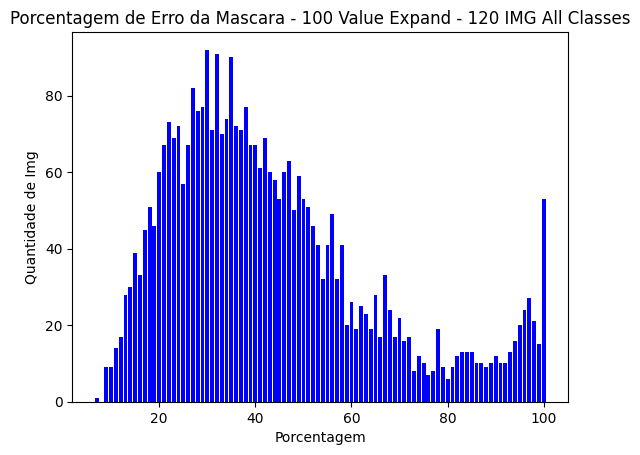

In [77]:
from collections import Counter

contagem = Counter(lista_resultado)

valores = list(contagem.keys())
frequencias = list(contagem.values())


plt.bar(valores, frequencias, color='blue')

plt.title(f"Porcentagem de Erro da Mascara - {descricao_img}")
plt.xlabel("Porcentagem")
plt.ylabel("Quantidade de Img")

plt.show()

In [78]:
new_list = []

for freq, val in zip(frequencias, valores):
    print(f"A porcentagem {val} apareceu {freq} vezes")

A porcentagem 36 apareceu 72 vezes
A porcentagem 50 apareceu 53 vezes
A porcentagem 82 apareceu 12 vezes
A porcentagem 66 apareceu 17 vezes
A porcentagem 74 apareceu 12 vezes
A porcentagem 52 apareceu 46 vezes
A porcentagem 60 apareceu 26 vezes
A porcentagem 47 apareceu 63 vezes
A porcentagem 23 apareceu 69 vezes
A porcentagem 58 apareceu 41 vezes
A porcentagem 22 apareceu 73 vezes
A porcentagem 44 apareceu 58 vezes
A porcentagem 61 apareceu 19 vezes
A porcentagem 43 apareceu 60 vezes
A porcentagem 49 apareceu 59 vezes
A porcentagem 59 apareceu 20 vezes
A porcentagem 16 apareceu 33 vezes
A porcentagem 11 apareceu 14 vezes
A porcentagem 10 apareceu 9 vezes
A porcentagem 25 apareceu 57 vezes
A porcentagem 87 apareceu 10 vezes
A porcentagem 96 apareceu 24 vezes
A porcentagem 32 apareceu 91 vezes
A porcentagem 97 apareceu 27 vezes
A porcentagem 53 apareceu 41 vezes
A porcentagem 65 apareceu 28 vezes
A porcentagem 99 apareceu 15 vezes
A porcentagem 17 apareceu 45 vezes
A porcentagem 18 apar

In [79]:
sum(frequencias), sum(valores)

(3488, 5021)

In [80]:
frequencias_diferentes_100 = []
full_error = []
for freq, val in zip(frequencias, valores):
  if val != 100:
    frequencias_diferentes_100.append(freq)
  else:
    full_error.append(freq)

In [81]:
sum(frequencias_diferentes_100), sum(full_error)

(3435, 53)

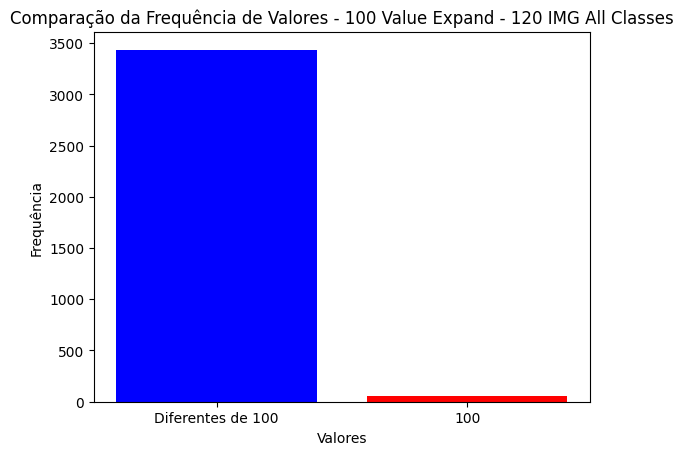

In [82]:
# ASC-H-100-909-16-frequencia

labels = ['Diferentes de 100', '100']

cores = ['blue', 'red']

soma_frequencias_diferentes_de_100 = sum(frequencias_diferentes_100)

frequencias = [soma_frequencias_diferentes_de_100, sum(full_error)]

x = range(len(frequencias))

plt.bar(x, frequencias, color=cores)

plt.title(f"Comparação da Frequência de Valores - {descricao_img}")
plt.xlabel("Valores")
plt.ylabel("Frequência")

plt.xticks(x, labels)

plt.show()